# Message Classifier Using Naive Bayes Algorithm

This project aims to use multinomial Naive Bayes algorithm to classify 5,572 SMS messages as either spam/non-spam. 

Implementation of the algorithm comprises of three steps: 
1. Teaching the computer how to classify messages using a dataset of already classified messages (by humans)
2. Using this human knowledge to estimate probabilities for new messages (P_spam and P_non_spam)
3. Comparing the probabilites (i.e. P_spam > P_non_spam => The message is a spam)

The metric used to score model performance will be accuracy. For starters the goal is to build a classifier that classifies messages with accuracy of at least 80%. As we'll see later, this goal was highly exceeded with the model reaching accuracy of over 98%.

(Please note: You can find more information about the dataset used as well as download link for the data in the README.md file of this project.)

## Importing and Exploring the Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None 
 -------------------------------------------------- 
   Label                                                SMS
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina... 
 -------------------------------------------------- 
      Label                                                SMS
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name 
 -------------------------------------------------- 
 ham     86.6
spam    13.4
Name: Label, dtype: float64


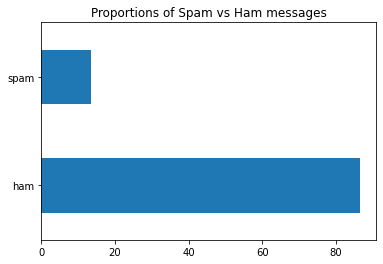

In [11]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import string

messages = pd.read_csv('SMSSpamCollection', sep = '\t', header = None, names = ['Label','SMS'])


print(messages.info(verbose = True), '\n',
      '-'*50,'\n',
      messages.head(3),'\n',
      '-'*50,'\n',
      messages.tail(3),'\n',
      '-'*50,'\n',
      round(messages['Label'].value_counts(normalize = True) * 100, 1))

spam_ham_proportions = messages['Label'].value_counts(normalize = True) * 100
spam_ham_proportions.plot.barh()
plt.title('Proportions of Spam vs Ham messages')
plt.show()


From the initial exploration we can see that our dataset contains 5572 mesages out of which 13.4% are labeled as 'spam' and 86.6% as 'ham' (non-spam). The dataset does not contain any missing values. Overall the sample looks representative.

## Splitting the Data

In order assess the performance of the classifier the data has been split to train and test dataset with ratio of 80% to 20% respectively. The train data will be used to teach the model how to classify unseen messages (in this cas the test dataset), whilst the test dataset (already labeled) will serve as a benchmark for our classification model.

In [12]:
#Randomize the dataset
messages_randomized = messages.sample(frac = 1, random_state = 1)

# Split the dataframe to train and test based on index
train = messages_randomized.iloc[:round(5572 * 0.8),:].reset_index(drop = True)
test = messages_randomized.iloc[round(5572 * 0.8):,:].reset_index(drop = True)

print(train['Label'].value_counts(normalize = True) * 100)
print(test['Label'].value_counts(normalize = True) * 100)

ham     86.54105
spam    13.45895
Name: Label, dtype: float64
ham     86.804309
spam    13.195691
Name: Label, dtype: float64


Inspection of the newly created test and train dataframes reveals that the proportions of 'spam' and 'ham' (non-spam) messages has been preserved, hence we can move forward with the data cleaning.

## Data Cleaning

In order to calculate probabilities of SMS messages being either spam/ham we need to perfrom some basic data cleaning. In particular punctuation will be removed and every letter will be transformed to lowercase. After that a word frequency table will be created.

In [13]:
train['SMS'] = train['SMS'].str.replace('\W',' ')
train['SMS'] = train['SMS'].str.lower()
train.head()

<ipython-input-13-5488d3961d36>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['SMS'] = train['SMS'].str.replace('\W',' ')


,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


## Creating a Word Frequency Table

In [14]:
train['SMS'] = train['SMS'].str.split()

vocabulary = []
for row in train['SMS']:
    for word in row:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))
print(len(vocabulary))

7783


The list 'vocabulary' contains unique words from our messages. This will be used to create a new dataframe (a word frequency table).

In [26]:
word_count_sms = {unique_word: [0] * len(train['SMS']) 
                  for unique_word in vocabulary}

for index, sms in enumerate(train['SMS']):
    for word in sms:
        word_count_sms[word][index] += 1


In [16]:
#The word frequency table
df_word_count_sms = pd.DataFrame(word_count_sms)
df_word_count_sms.head()

,chase,shldxxxx,worrying,dreams,sky,jamz,browser,had,gd,asssssholeeee,...,mtmsg,imat,hillsborough,beauties,ctla,shortly,madstini,swoop,077xxx,set
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
train_clean = pd.concat([train, df_word_count_sms], axis = 1)
train_clean.head()

,Label,SMS,chase,shldxxxx,worrying,dreams,sky,jamz,browser,had,...,mtmsg,imat,hillsborough,beauties,ctla,shortly,madstini,swoop,077xxx,set
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Multinomial Naive Bayes Implementation

Now that we have clean data we can begin with implementation of the algorithm following formulas below.
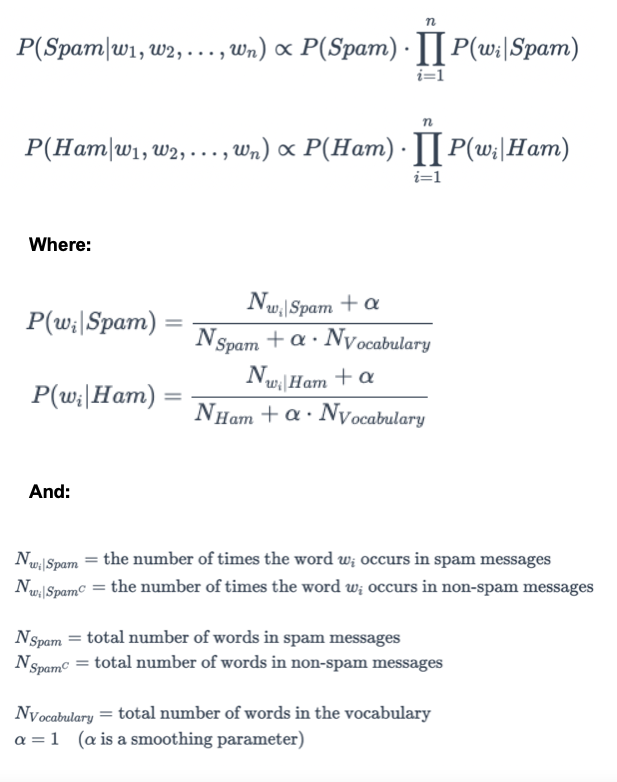


In [18]:
# Isolating Spam nad Ham messages
spam_messages = train_clean[train_clean['Label'] == 'spam']
ham_messages = train_clean[train_clean['Label'] == 'ham']

# Calculating P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(train_clean)
p_ham = len(ham_messages) / len(train_clean)


#N_Vocabulary
N_vocabulary = len(vocabulary)

#N_Spam
N_spam = spam_messages['SMS'].apply(len).sum()

#N_Ham
N_ham = ham_messages['SMS'].apply(len).sum()

# Laplace smoothing
alpha = 1

# Calculating parameters P(w|Spam) and p(w|Ham) for each word

dict_spam = {}
dict_ham = {}

for word in vocabulary:
    dict_spam[word] = 0
    dict_ham[word] = 0
    
for word in vocabulary:
    n_w_spam = spam_messages[word].sum()
    n_w_ham = ham_messages[word]. sum() 
    
    p_w_spam = (n_w_spam + alpha) / ( N_spam + alpha * N_vocabulary)
    p_w_ham = (n_w_ham + alpha) / (N_ham + alpha * N_vocabulary)
    
    dict_spam[word] = p_w_spam
    dict_ham[word] = p_w_ham

## Building the Classifier Function

The function does the following:
1. Takes in a new message
    
2. Calculates probabilities that a given message is Spam/Ham given the words it contains (i.e. P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn).
    
3. Compares the values and classifies the message as:
    - Ham if P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn)
    - Spam if P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn)
    - Needs human classfification if P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn)

In [19]:
def classify(message):
    """
    message : a string
    """
    
    # Cleaning the new message
    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam 
    p_ham_given_message = p_ham
    
    
    for word in message:
        if word in dict_spam:
            p_spam_given_message *= dict_spam[word]
        if word in dict_ham:
            p_ham_given_message *= dict_ham[word]
    
#     print('P(Spam|message):', p_spam_given_message)
#     print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [20]:
# Testing the function for Ham (uncommenting the code in the above function will display the subsequent probabilities)
print(classify("Sounds good, Tom, then see u there"))

ham


In [21]:
# Testing the function for Spam (uncommenting the code in the above function will display the subsequent probabilities)
print(classify('WINNER!! This is the secret code to unlock the money: C3421.'))

spam


## Classifying Messages and Measuring Accuracy

Since we have created dictionaries containing calculated probabilites for each word, classifying each message in our test dataset will be quick and computationally inexpensive.

In [22]:
test['predicted'] = test['SMS'].apply(classify)
test.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [23]:
test['correct'] = test['Label'] == test['predicted']
test.head()

,Label,SMS,predicted,correct
0,ham,Later i guess. I needa do mcat study too.,ham,True
1,ham,But i haf enuff space got like 4 mb...,ham,True
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam,True
3,ham,All sounds good. Fingers . Makes it difficult ...,ham,True
4,ham,"All done, all handed in. Don't know if mega sh...",ham,True


In [24]:
# Measuring accuracy
correct_incorrect = test['correct'].value_counts()
correct = correct_incorrect[1]
accuracy = correct / len(test)
print('Correctly classified:',correct_incorrect[1],'\n',
      'Incorrectly classified:',correct_incorrect[0],'\n',
      'Accuracy:',accuracy * 100)

Correctly classified: 1100 
 Incorrectly classified: 14 
 Accuracy: 98.74326750448833


## Conclusion

To sum up, this project leveraged the power of multunomial Naive Bayes algorithm to classifiy SMS messages. The model was created such that tasks that were most computationaly expensive were conducted before the classification of test data itself. This means that application of the classifier on new messages is very fast and hence might be feasible for a real world application. Moreover, given our initial target of creating a classification model with accuracy of at least 80%, our model highly exceeded every expectation. Only 14 of the 1100 messages has been incorrectly classified yielding accuracy of 98,74%.

## Next Steps

As with almost every project there are areas for improvement. To name a couple:

1. Analyzing the 14 incorrectly classified messages to understand why the algorithm classified them incorrectly

2. By making the algorithm sensitive to letter case we can make the classification process more complex
